# Grover's Algorithm

In [27]:
#All the code developed here was made by Victor

# initialization
import matplotlib.pyplot as plt
import numpy as np
from qiskit.tools.monitor import job_monitor
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.library import ZGate

# import basic plot tools
from qiskit.visualization import plot_histogram

IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-11-12 08:08:31,417: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [28]:
#Apply two cnot gates one controled by v1 and the other by v2, target as edge 
def XOR(qc, v1, v2, edge):
    qc.cx(v1, edge)
    qc.cx(v2, edge)

#The idea of the adder implementation came from https://www.youtube.com/watch?v=7qFOWvcIhC8
#But the code was developed by Victor
def Adder(qc, Q_Edges,Q_Sum,Q_Carry):
    for e in range(len(Q_Edges)):
        Q_e0=Q_Edges[e] # Qubit we will sum with Q_Sum (s3s2s1s0)
        qc.ccx(Q_e0, Q_Sum[0], Q_Carry[0])
        qc.cx (Q_e0,Q_Sum[0])

        qc.ccx (Q_Carry[0],Q_Sum[1],Q_Carry[1])
        qc.cx (Q_Carry[0],Q_Sum[1])

        qc.ccx (Q_Carry[1],Q_Sum[2],Q_Carry[2])
        qc.cx (Q_Carry[1],Q_Sum[2])

        qc.cx (Q_Carry[2],Q_Sum[3])

        #zero carry, so that following sums can use adder

        qc.x(Q_Sum[2])
        qc.ccx (Q_Carry[1],Q_Sum[2],Q_Carry[2])
        qc.x(Q_Sum[2])

        qc.x(Q_Sum[1])
        qc.ccx (Q_Carry[0],Q_Sum[1],Q_Carry[1])
        qc.x(Q_Sum[1])

        qc.x(Q_Sum[0])
        qc.ccx(Q_e0, Q_Sum[0], Q_Carry[0])
        qc.x(Q_Sum[0])

#Verify if cut size equals to Target_s3s2s1s0
def VerifyCutSize_Flip(qc, Q_Sum, Q_output, Target_s3s2s1s0):
    Ts3,Ts2,Ts1,Ts0=Target_s3s2s1s0
    if Ts0==0:
        qc.x(Q_Sum[0])

    if Ts1==0:
        qc.x(Q_Sum[1])

    if Ts2==0:
        qc.x(Q_Sum[2])

    if Ts3==0:
        qc.x(Q_Sum[3])

    qc.mcx(Q_Sum,Q_output) #Flip qubit if the sum from the adder equal the target

    if Ts0==0:
        qc.x(Q_Sum[0])

    if Ts1==0:
        qc.x(Q_Sum[1])

    if Ts2==0:
        qc.x(Q_Sum[2])

    if Ts3==0:
        qc.x(Q_Sum[3])
    

def oracle_P1(qc, Q_Vertices, Q_Edges,Q_Sum,Q_Carry,Q_output,list_edges,Target_s3s2s1s0):
    #Compute Edge Clauses (Check if vertices belong the the same set)
    i = 0
    for clause in list_edges:
        XOR(qc, Q_Vertices[clause[0]], Q_Vertices[clause[1]], Q_Edges[i])
        i += 1

    #Adder
    Adder(qc, Q_Edges,Q_Sum,Q_Carry)


def oracle(qc,qc_Uncompute, Q_Vertices, Q_Edges,Q_Sum,Q_Carry,Q_output,list_edges,Target_s3s2s1s0):

    #Compute Edge Clauses (Check if vertices belong the the same set)
    i = 0
    for clause in list_edges:
        XOR(qc, Q_Vertices[clause[0]], Q_Vertices[clause[1]], Q_Edges[i])
        i += 1

    #Adder
    Adder(qc, Q_Edges,Q_Sum,Q_Carry)

    # # Flip 'output' bit if all clauses are satisfied
    VerifyCutSize_Flip(qc, Q_Sum, Q_output, Target_s3s2s1s0)
    qc.barrier() 
    # Uncompute
    # Uncompute clauses to reset clause-checking bits to 0
    new_qc=qc & qc_Uncompute.inverse()

    return new_qc


def difuser(qc,var_qubits):
    for i in range(len(var_qubits)):
        qc.h(i)
        qc.x(i)
        
    czz = ZGate().control(len(var_qubits)-1)
    qc.append(czz, range(len(var_qubits)))

    for i in range(len(var_qubits)):
        qc.x(i)
        qc.h(i)

In [31]:
#Gamma:Number of Oracle-Diffuser Repetitions:
def RunGroverMaxCut(Gamma=2, CutSize=8, RunSimulator=True):
    list_edges = [[0,1],[0,3],[0,4],[0,5],[1,2],[1,5],[2,3],[2,4],[2,5],[3,4],[4,5]]
    TargetNumEdges=CutSize
    Target_s3s2s1s0=[int(x) for x in list('{0:04b}'.format(TargetNumEdges))] #s3 ,s2, s1, s0

    #Create separate registers to name bits
    Q_Vertices = QuantumRegister(6, name='v')   #Qubits to represent vertices
    Q_Edges    = QuantumRegister(11, name='e')  #Qubits to represent edges
    Q_Sum      = QuantumRegister(4, name='s')   #Qubits to represent 4 qubit sum s4s3s2s1
    Q_Carry    = QuantumRegister(3, name='c')   #Qubits to work as carry for the 4 bit sum
    Q_output = QuantumRegister(1, name='o')  #Output qubit (if s3s2s1s0==x3x2x1x0 return 1, 0 otherwise)
    cbits = ClassicalRegister(6, name='cbits')  #Classical bits to perfrom measurement

    qc_Uncompute = QuantumCircuit(Q_Vertices, Q_Edges, Q_Sum,Q_Carry,Q_output,cbits)
    oracle_P1(qc_Uncompute, Q_Vertices, Q_Edges,Q_Sum,Q_Carry,Q_output,list_edges,Target_s3s2s1s0)


    qc = QuantumCircuit(Q_Vertices, Q_Edges, Q_Sum,Q_Carry,Q_output,cbits)

    # Initialize 'Q_output' in state |->
    qc.initialize([1, -1]/np.sqrt(2), Q_output)

    # Initialize vertices qubits
    qc.h(Q_Vertices)
    qc.barrier()  # for visual separation

    for i in range(Gamma):
        
        #Apply our oracle
        qc=oracle(qc,qc_Uncompute, Q_Vertices, Q_Edges,Q_Sum,Q_Carry,Q_output,list_edges,Target_s3s2s1s0)
        qc.barrier()  # for visual separation
        difuser(qc,Q_Vertices)

    # Measure
    qc.measure(Q_Vertices, cbits)

    #qc.draw(output='mpl')

    if RunSimulator==True:
        provider = IBMQ.get_provider(hub='ibm-q')
        provider.backends()
        #backend = provider.get_backend('ibm_brisbane')
        backend = provider.get_backend('simulator_mps')
        shots = 2000
        transpiled_bv_circuit = transpile(qc, backend,optimization_level=3)
        job = backend.run(transpiled_bv_circuit, shots=shots)

        job_monitor(job, interval=2)
        # Get the results from the computation
        results = job.result()
        answer = results.get_counts()

    else:
        provider = IBMQ.get_provider(hub='ibm-q')
        provider.backends()
        backend = provider.get_backend('ibm_brisbane')
        #backend = provider.get_backend('simulator_mps')
        shots = 2000
        transpiled_bv_circuit = transpile(qc, backend,optimization_level=3)
        job = backend.run(transpiled_bv_circuit, shots=shots)

        job_monitor(job, interval=2)
        # Get the results from the computation
        results = job.result()
        answer = results.get_counts()

    return plot_histogram(answer,number_to_keep=20)

Job Status: job has successfully run


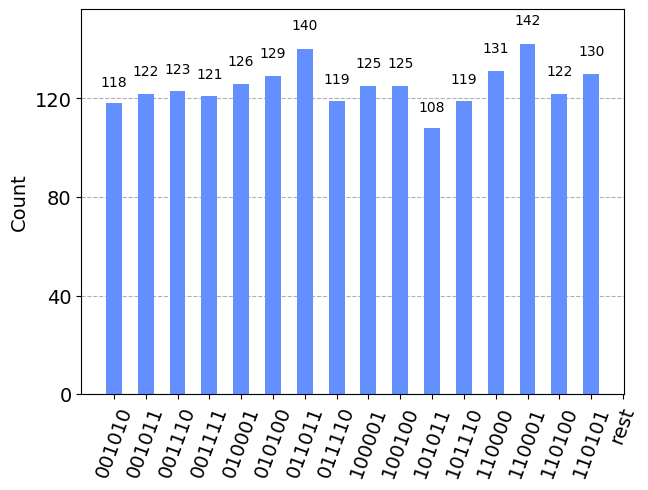

In [32]:
#Simulate CutSize=6, Gamma=1, Simulator
RunGroverMaxCut(Gamma=1, CutSize=6, RunSimulator=True)

Job Status: job has successfully run


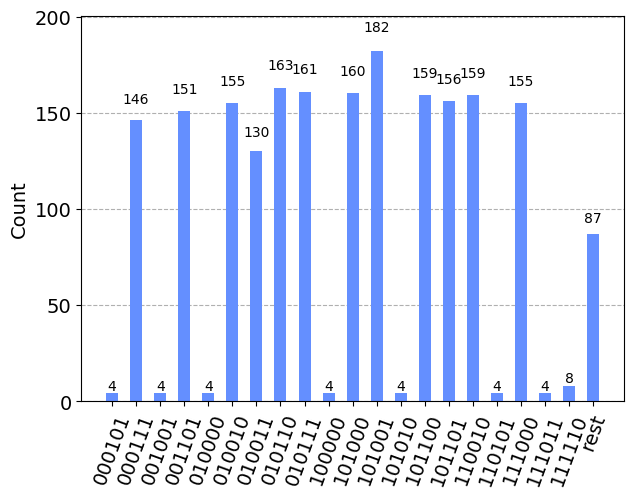

In [33]:
#Simulate CutSize=7, Gamma=1, Simulator
RunGroverMaxCut(Gamma=1, CutSize=7, RunSimulator=True)

Job Status: job has successfully run


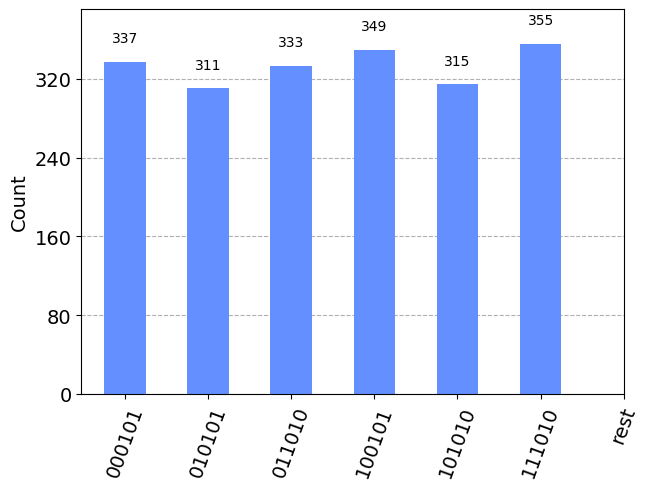

In [37]:
#Simulate CutSize=8, Gamma=2, Simulator
RunGroverMaxCut(Gamma=2, CutSize=8, RunSimulator=True)

Job Status: job has successfully run


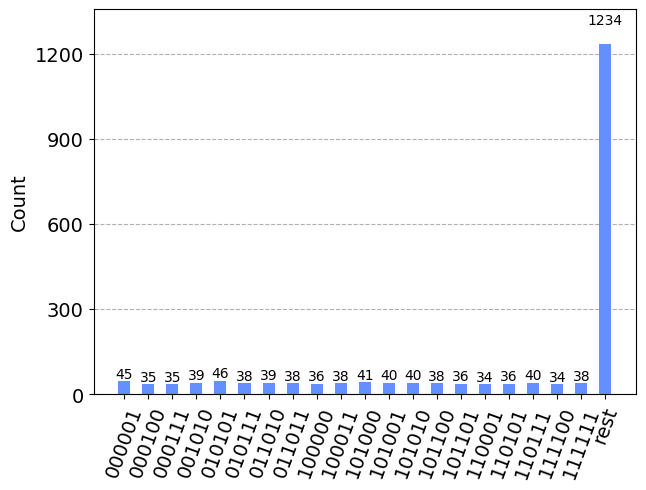

In [35]:
#Simulate CutSize=8, Gamma=2, Simulator
RunGroverMaxCut(Gamma=2, CutSize=9, RunSimulator=True)

Job Status: job has successfully run


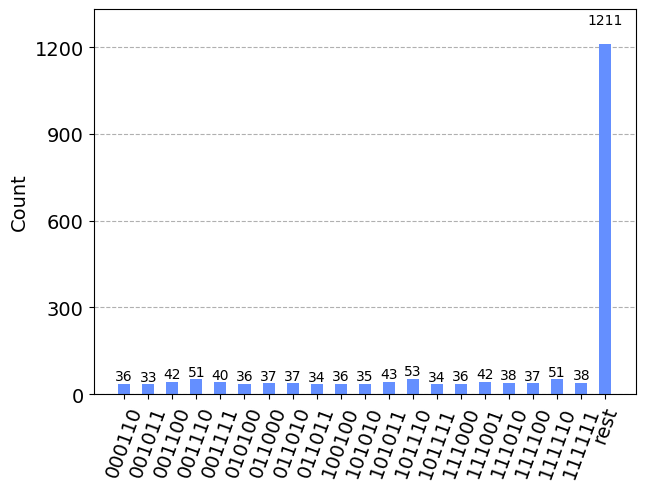

In [38]:
#Simulate CutSize=8, Gamma=2, Real Quantum Computer
RunGroverMaxCut(Gamma=2, CutSize=8, RunSimulator=False)